In [1]:
# !cd ml/LearnToPayAttention && python train.py --attn_mode before --outf logs_before --normalize_attn --log_images


In [2]:
import os
import sys
import multiprocessing

sys.path.append(os.path.abspath(os.path.join("./ml_image_organizer")))
sys.path.append(os.path.abspath(os.path.join("./ml/LearnToPayAttention/")))

import csv
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.models import inception_v3
from sklearn.model_selection import KFold
from tqdm import tqdm
from torchsummary import summary
from PIL import Image
import json
import random
import argparse
from tensorboardX import SummaryWriter
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms
from model1 import AttnVGG_before
from model2 import AttnVGG_after
from utilities import *
import datetime
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

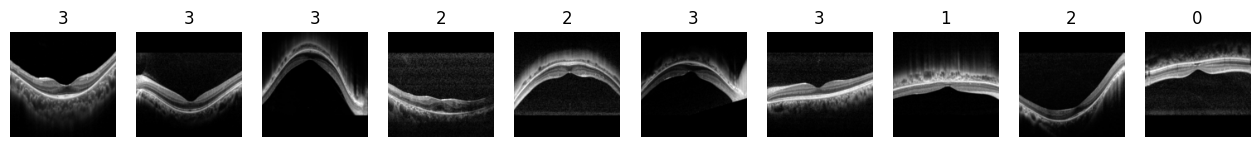

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


my_dataset_root = "/mnt/c/Users/Sean/Downloads/OCT_DATASET_DO_NOT_SHARE_WITH_ANYONE_split"
im_size = 128
crop_size = 5

transform_train = transforms.Compose(
    [
        # transforms.RandomCrop(im_size, padding=4),
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.Resize((im_size + 2 * crop_size, im_size + 2 * crop_size)),
        transforms.Lambda(
            lambda img: img.crop((crop_size, crop_size, img.width - crop_size, img.height - crop_size))
        ),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.1),
        transforms.ToTensor(),
    # transforms.Normalize(mean=[0.11,0.11,0.11], std=[0.18,0.18,0.18])
        # transforms.Normalize(
        # convert to [0,1]
        transforms.Lambda(lambda img: img / np.max(img.numpy())),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.Resize((im_size, im_size)),
        transforms.ToTensor(),
        # transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
        # convert to [0,1]
        transforms.Lambda(lambda img: img / np.max(img.numpy())),
    ]
)

# Visualize a few images
batch_size = 10
# Define the training, validation, and test datasets
train_dataset = ImageFolder(root=my_dataset_root + '/train', transform=transform_train)
val_dataset = ImageFolder(root=my_dataset_root + '/val', transform=transform_test)
test_dataset = ImageFolder(root=my_dataset_root + '/test', transform=transform_test)

# Create data loaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
data_iter = iter(train_loader)
for i in range(1):
    images, scalars = next(data_iter)
    image_array = images.numpy()
    scalar_array = scalars.numpy()

    # visualize batch on one row
    fig, axes = plt.subplots(1, batch_size, figsize=(16, 4))
    for i in range(batch_size):
        axes[i].imshow(image_array[i].transpose(1, 2, 0))
        axes[i].set_title(scalar_array[i])
        axes[i].axis("off")
    plt.show()





In [4]:
date_hour_min = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
num_folds = 5
opt = argparse.Namespace()
opt.batch_size = 1
opt.epochs = 300
opt.lr = 0.001
opt.outf = "logs/ltpa_" + date_hour_min
opt.attn_mode = "before"
opt.normalize_attn = True
opt.no_attention = False
opt.log_images = True

def main():
    num_aug = 3

    net = AttnVGG_before(
        im_size=im_size,
        num_classes=4,
        attention=not opt.no_attention,
        normalize_attn=opt.normalize_attn,
        init="xavierUniform",
    )
    criterion = nn.CrossEntropyLoss()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device_ids = [0]
    model = nn.DataParallel(net, device_ids=device_ids).to(device)
    criterion.to(device)

    ### optimizer
    # optimizer = optim.SGD(model.parameters(), lr=opt.lr, momentum=0.9, weight_decay=5e-4)
    optimizer = optim.Adam(model.parameters(), lr=opt.lr)

    # lr_lambda = lambda epoch: np.power(0.5, int(epoch / 25))
    # scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    # training
    step = 0
    writer = SummaryWriter(opt.outf)
    for epoch in range(opt.epochs):
        images_disp = []
        writer.add_scalar("train/learning_rate", optimizer.param_groups[0]["lr"], epoch)
        print("\nepoch %d learning rate %f\n" % (epoch, optimizer.param_groups[0]["lr"]))
        # run for one epoch
        for aug in range(num_aug):
            for i, data in enumerate(train_loader, 0):
                # warm up
                model.train()
                model.zero_grad()
                optimizer.zero_grad()
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                if (aug == 0) and (i == 0):  # archive images in order to save to logs
                    images_disp.append(inputs[0:36, :, :, :])
                # forward
                pred, __, __, __ = model(inputs)
                # backward
                loss = criterion(pred, labels.view(-1, 1))
                loss.backward()
                optimizer.step()
                # display results
                if i % 10 == 0:
                    model.eval()
                    pred, __, __, __ = model(inputs)
                    loss = criterion(pred, labels)
                    writer.add_scalar("train/loss", loss.item(), step)
                    print(f"[epoch {epoch}][aug {aug}/{num_aug-1}][{i}/{len(train_loader)-1}] loss {loss.item():.4f}")
                step += 1
        # the end of each epoch: test & log
        # print("\none epoch done, saving records ...\n")
        # torch.save(model.state_dict(), os.path.join(opt.outf, "net.pth"))
        # if epoch == opt.epochs / 2:
        #     torch.save(model.state_dict(), os.path.join(opt.outf, "net%d.pth" % epoch))
        model.eval()
        with torch.no_grad():
            # log scalars
            for i, data in enumerate(val_loader, 0):
                images_test, labels_test = data
                images_test, labels_test = images_test.to(device), labels_test.to(device)
                if i == 0:  # archive images in order to save to logs
                    images_disp.append(inputs[0:36, :, :, :])
                pred_test, __, __, __ = model(images_test)
                loss = criterion(pred_test, labels_test)
            print("\n[epoch %d] loss on test data: %.2f\n" % (epoch, loss.item()))
            # log images
            if opt.log_images:
                print("\nlog images ...\n")
                I_train = utils.make_grid(images_disp[0], nrow=6, normalize=True, scale_each=True)
                writer.add_image("train/image", I_train, epoch)
                if epoch == 0:
                    I_test = utils.make_grid(images_disp[1], nrow=6, normalize=True, scale_each=True)
                    writer.add_image("test/image", I_test, epoch)
            if opt.log_images and (not opt.no_attention):
                print("\nlog attention maps ...\n")
                # base factor
                if opt.attn_mode == "before":
                    min_up_factor = 1
                else:
                    min_up_factor = 2
                # sigmoid or softmax
                if opt.normalize_attn:
                    vis_fun = visualize_attn_softmax
                else:
                    vis_fun = visualize_attn_sigmoid
                # training data
                __, c1, c2, c3 = model(images_disp[0])
                if c1 is not None:
                    attn1 = vis_fun(I_train, c1, up_factor=min_up_factor, nrow=6)
                    writer.add_image("train/attention_map_1", attn1, epoch)
                if c2 is not None:
                    attn2 = vis_fun(I_train, c2, up_factor=min_up_factor * 2, nrow=6)
                    writer.add_image("train/attention_map_2", attn2, epoch)
                if c3 is not None:
                    attn3 = vis_fun(I_train, c3, up_factor=min_up_factor * 4, nrow=6)
                    writer.add_image("train/attention_map_3", attn3, epoch)
                # test data
                __, c1, c2, c3 = model(images_disp[1])
                if c1 is not None:
                    attn1 = vis_fun(I_test, c1, up_factor=min_up_factor, nrow=6)
                    writer.add_image("test/attention_map_1", attn1, epoch)
                if c2 is not None:
                    attn2 = vis_fun(I_test, c2, up_factor=min_up_factor * 2, nrow=6)
                    writer.add_image("test/attention_map_2", attn2, epoch)
                if c3 is not None:
                    attn3 = vis_fun(I_test, c3, up_factor=min_up_factor * 4, nrow=6)
                    writer.add_image("test/attention_map_3", attn3, epoch)


if __name__ == "__main__":
    main()



epoch 0 learning rate 0.001000



RuntimeError: 0D or 1D target tensor expected, multi-target not supported